# Pokemon Dataset

This notebook walks through dataset generation and a simple round of model building.  There is one image per pokemon in the `images` folder.  Each pokemon has one or two types.  The goal of this project is to build a model that can predict the type(s) of a pokemon given an image of it.  

# Build Dataset Pipeline 
 
Tensorflow works best when data is organized into an input pipeline.  These pipelines help organize, batch, shuffle, and serve your data to CPU/GPU during learning.   The [`tf.data`](https://www.tensorflow.org/api_docs/python/tf/data) module API assists with this.  

The main structure is the `tf.data.Dataset` object.  It loads data from disk, applies optimized transformations, creates batches, and sends it to CPU/GPU.  

[Google blog post on tf.data.Datasets](https://developers.googleblog.com/2017/09/introducing-tensorflow-datasets.html)   
[Tutorial on tf.data](https://www.tensorflow.org/guide/data)   
[Advanced guide on tf.data](https://www.tensorflow.org/guide/data)   

--- 

We take these steps:  
+ Preliminary Data Exploration 
+ Data Preprocessing 
+ Data Pipeline 

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt 
import seaborn as sns

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers 

from PIL import Image 

print(tf.__version__)

2.1.0


Pokemon CSV contains the names and types of our pokemon.  The types are in two separate columns.  

In [2]:
df = pd.read_csv('pokemon.csv')
df.head()

,Name,Type1,Type2
0,bulbasaur,Grass,Poison
1,ivysaur,Grass,Poison
2,venusaur,Grass,Poison
3,charmander,Fire,NaN
4,charmeleon,Fire,NaN


In [3]:
LABELS = df['Type1'].unique()
print(LABELS)

['Grass' 'Fire' 'Water' 'Bug' 'Normal' 'Poison' 'Electric' 'Ground'
 'Fairy' 'Fighting' 'Psychic' 'Rock' 'Ghost' 'Ice' 'Dragon' 'Dark' 'Steel'
 'Flying']


In [4]:
def merge_type_strings(row): 
    t1 = row['Type1']
    t2 = row['Type2']
    
    if t2 is np.nan: 
        return t1
    
    return t1 + ' ' + t2
    


df['Type'] = df.apply(lambda row: merge_type_strings(row), axis=1)
df.head()

,Name,Type1,Type2,Type
0,bulbasaur,Grass,Poison,Grass Poison
1,ivysaur,Grass,Poison,Grass Poison
2,venusaur,Grass,Poison,Grass Poison
3,charmander,Fire,NaN,Fire
4,charmeleon,Fire,NaN,Fire


## Preliminary data exploration 
### Analyze label frequencies 


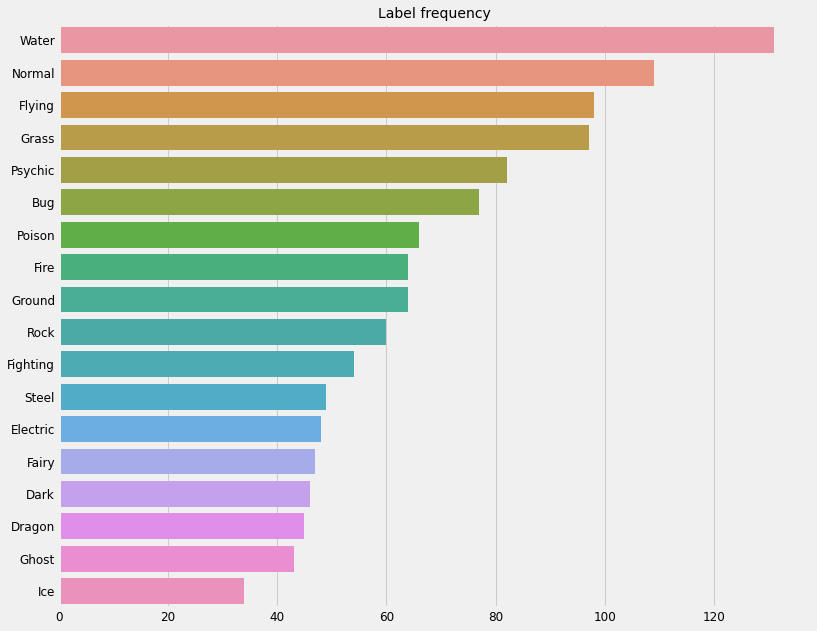

In [5]:
# Get label frequencies in descending order
label_freq = df['Type'].apply(lambda s: str(s).split(' ')).explode().value_counts().sort_values(ascending=False)

# Bar plot
mpl.style.use("fivethirtyeight")
plt.figure(figsize=(12,10))
sns.barplot(y=label_freq.index.values, x=label_freq, order=label_freq.index)
plt.title("Label frequency", fontsize=14)
plt.xlabel("")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [25]:
# TODO more data exploration 

## Data Preparation 

Our goal is to produce a `tf.data.Dataset` that serves (image, label) batches during training.  

image:  a normalized, rescaled RBG tensor.  Shape is (DIM_H, DIM_W, 3)   
label:  a multi-hot encoded vector of types.  A pokemon can have 1 or 2 types.  

### Fix Type column so that its a list of Types 

In [6]:
# First, make the Type column a list 
df['Type'] = df['Type'].apply(lambda s: [l for l in str(s).split(' ')])
df.head()

,Name,Type1,Type2,Type
0,bulbasaur,Grass,Poison,"[Grass, Poison]"
1,ivysaur,Grass,Poison,"[Grass, Poison]"
2,venusaur,Grass,Poison,"[Grass, Poison]"
3,charmander,Fire,NaN,[Fire]
4,charmeleon,Fire,NaN,[Fire]


### Train/Validation/Test split 


In [7]:
from sklearn.model_selection import train_test_split


X_temp, X_test, y_temp, y_test = train_test_split(df['Name'], df['Type'], test_size=0.1)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1)

print("Training set size: \t", len(X_train))
print("Validation set size: \t", len(X_val))
print("Test set size: \t\t", len(X_test))


Training set size: 	 655
Validation set size: 	 73
Test set size: 		 81


### Add label for filepath 

Temporarily, we will let our X variables represent the path to an image file.  

In [8]:
import os 

X_train =  [os.path.join("./images/", str(f) + '.png') for f in X_train] 
X_val =  [os.path.join("./images/", str(f) + '.png') for f in X_val] 
X_test =  [os.path.join("./images/", str(f) + '.png') for f in X_test] 
       
            
X_train[:3]

['./images/bouffalant.png', './images/corphish.png', './images/trubbish.png']

### Turn labels into lists 
Convert y variables from Series to list form.  Easier to process and index when building the pipeline.  

In [9]:
y_train = list(y_train)
y_val = list(y_val)
y_test = list(y_test)

y_train[:3]

[['Normal'], ['Water'], ['Poison']]

### View data 
Display some images to verify the state of our X and y so far.  

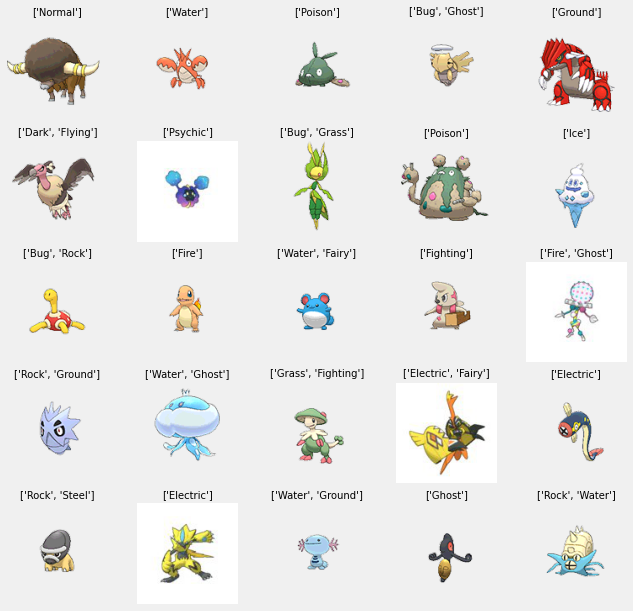

In [10]:
fig, axes = plt.subplots(5, 5, figsize=(10, 10))

for i, ax in enumerate(axes.reshape(-1)):
    
    img_path = X_train[i]
    label = y_train[i]   
    
    ax.set_title(label, size=10)
    ax.imshow(Image.open(str(img_path)))
    ax.axis(False)
    

### Label encoding 
Using sklearn's `MultiLabelBinarizer` to multi-hot encode the labels.  

In [306]:
from sklearn.preprocessing import MultiLabelBinarizer

type_encoding = {}

mlb = MultiLabelBinarizer()
mlb.fit(y_train)

print("Labels: ")
# Loop over all labels and show 
N_LABELS = len(mlb.classes_)
for i, label in enumerate(mlb.classes_): 
    print("{}. {}".format(i, label))
    type_encoding[i] = label 
    

Labels: 
0. Bug
1. Dark
2. Dragon
3. Electric
4. Fairy
5. Fighting
6. Fire
7. Flying
8. Ghost
9. Grass
10. Ground
11. Ice
12. Normal
13. Poison
14. Psychic
15. Rock
16. Steel
17. Water


In [12]:
# transform the targets of the training and test sets
y_train_bin = mlb.transform(y_train)
y_val_bin = mlb.transform(y_val)
y_test_bin = mlb.transform(y_test)


# Print example of movie posters and their binary targets
for i in range(3):
    print(X_train[i], y_train_bin[i])


./images/bouffalant.png [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
./images/corphish.png [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
./images/trubbish.png [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]


## Data Pipeline 

We are ready to build the tf.data.Dataset.  In these functions, you _must_ use tf API and operate with tensor objects.  

In [14]:
img = Image.open('images/bulbasaur.png')
IMG_HEIGHT, IMG_WIDTH = img.height, img.width
CHANNELS = 3

In [15]:
def parse_function(filename, label): 
    """ Returns a tuple of (normalized image array, label)  
    
    filename:  string representing path to image 
    label: multi-hot encoded array of size N_LABELS 
    """
    
    # Read image from file 
    img_string = tf.io.read_file(filename)
    
    # Decode it into a dense vector 
    img_decoded = tf.image.decode_png(img_string, channels=CHANNELS)
    
    # Resize it to a fixed shape 
    img_resized = tf.image.resize(img_decoded, [IMG_HEIGHT, IMG_WIDTH])
    
    # Normalize it to 0-1 scale 
    img_normed = img_resized / 255.0
    
    return img_normed, label 

In [16]:
BATCH_SIZE = 32 
AUTOTUNE = tf.data.experimental.AUTOTUNE # Adapt preprocessing and prefetching dynamically
SHUFFLE_BUFFER_SIZE = 8    # Shuffle the training data by a chunck of 8 observations


In [17]:
def create_dataset(filenames, labels, is_training=True): 
    """ Load and parse a tf.data.Dataset.  
    
    filenames: list of image paths 
    labels: numpy array of shape (BATCH_SIZE, N_LABELS)
    """
        
    # Create a first dataset of file paths and labels
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    # Parse and preprocess observations in parallel
    dataset = dataset.map(parse_function, num_parallel_calls=AUTOTUNE)
    
    if is_training == True:
        # This is a small dataset, only load it once, and keep it in memory.
        dataset = dataset.cache()
        # Shuffle the data each buffer size
        dataset = dataset.shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)
        
    # Batch the data for multiple steps
    dataset = dataset.batch(BATCH_SIZE)
    # Fetch batches in the background while the model is training.
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    
    return dataset

In [18]:
train_ds = create_dataset(X_train, y_train_bin)
val_ds = create_dataset(X_val, y_val_bin)
test_ds = create_dataset(X_test, y_test_bin)

## Examine the `tf.data.Dataset`

Shapes of items in dataset: 
```
features:  (BATCH SIZE, IMG_HEIGHT, IMG_WIDTH, CHANNELS)    
label:     (BATCH_SIZE, N_LABELS)

```

Shape of features array: (32, 120, 120, 3)
Shape of labels array: (32, 18)

Plot one of the images from the first batch


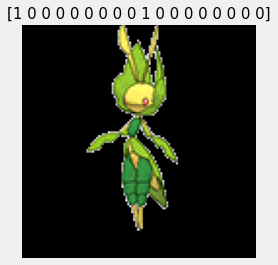

In [53]:
for f, l in train_ds.take(1):
    print("Shape of features array:", f.numpy().shape)
    print("Shape of labels array:", l.numpy().shape)
    
    print("\nPlot one of the images from the first batch")
    plt.imshow(f[0])
    plt.title(str(l.numpy()[0]), size=15)
    plt.axis(False)

Use .take(n) to gave `n` batches.  We set batch_size to 32.  

---
---
# Model Building 

We build a crappy model here just to verify that the dataset is working gud.  

In [361]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten  

model = tf.keras.Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS)), 
    MaxPooling2D((2, 2)), 
    Conv2D(64, (3, 3), activation='relu'), 
    MaxPooling2D((2, 2)), 
    Conv2D(64, (3, 3), activation='relu'), 
    Flatten(), 
    Dense(64, activation='relu'), 
    Dense(N_LABELS), 
])

In [362]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 118, 118, 32)      896       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 59, 59, 32)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 57, 57, 64)        18496     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 26, 26, 64)        36928     
_________________________________________________________________
flatten_10 (Flatten)         (None, 43264)             0         
_________________________________________________________________
dense_20 (Dense)             (None, 64)              

In [363]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), 
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
              metrics=[tf.keras.metrics.TopKCategoricalAccuracy(k=2)])

In [364]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',patience=10, verbose=0
)

callbacks = [early_stopping]

In [365]:
history = model.fit(train_ds, 
                   epochs=500, 
                   validation_data=val_ds, 
                   callbacks=callbacks, 
                   verbose=1)

Train for 21 steps, validate for 3 steps
Epoch 1/500
21/21 [==============================] - 1s 44ms/step - loss: 0.6582 - top_k_categorical_accuracy: 0.1099 - val_loss: 0.6115 - val_top_k_categorical_accuracy: 0.0959
Epoch 2/500
21/21 [==============================] - 0s 18ms/step - loss: 0.5858 - top_k_categorical_accuracy: 0.1481 - val_loss: 0.5326 - val_top_k_categorical_accuracy: 0.0959
Epoch 3/500
21/21 [==============================] - 0s 17ms/step - loss: 0.5129 - top_k_categorical_accuracy: 0.1481 - val_loss: 0.4656 - val_top_k_categorical_accuracy: 0.0959
Epoch 4/500
21/21 [==============================] - 0s 18ms/step - loss: 0.4478 - top_k_categorical_accuracy: 0.1573 - val_loss: 0.4228 - val_top_k_categorical_accuracy: 0.0685
Epoch 5/500
21/21 [==============================] - 0s 18ms/step - loss: 0.3977 - top_k_categorical_accuracy: 0.1527 - val_loss: 0.3903 - val_top_k_categorical_accuracy: 0.0959
Epoch 6/500
21/21 [==============================] - 0s 17ms/step - l

Plot the learning curves 

3/3 - 0s - loss: 0.2718 - top_k_categorical_accuracy: 0.3210


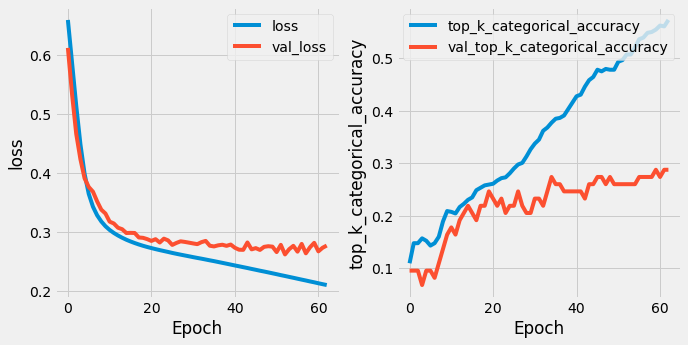

In [366]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes.reshape(-1, 1)


for idx, ax in enumerate(axes): 

    axes[idx].plot(history.history[keys[idx]], label=keys[idx])
    axes[idx].plot(history.history["val_" + keys[idx]], label = "val_" + keys[idx])
    axes[idx].set_xlabel('Epoch')
    axes[idx].set_ylabel(keys[idx])
    axes[idx].legend()

test_loss, test_acc = model.evaluate(test_ds, verbose=2)

## Visualize results 

Predictions on trainig set 

In [367]:
l = [0, 1]
nl = []
for it in l: 
    nl.append(type_encoding[it])
nl

['Bug', 'Dark']

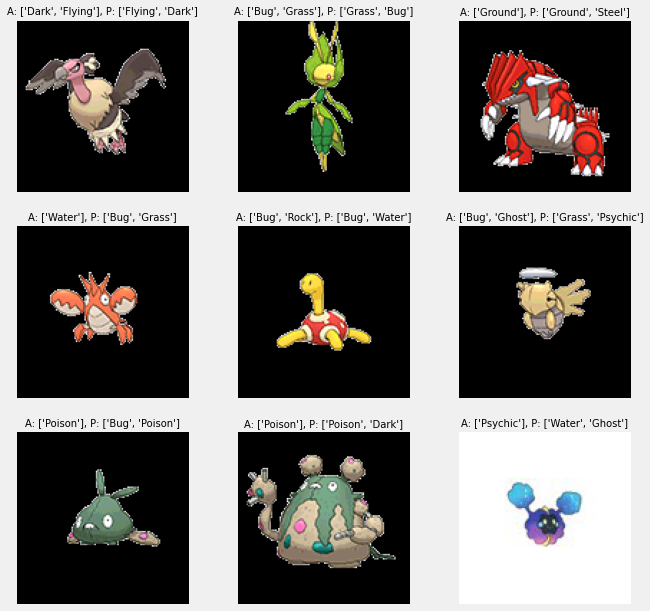

In [390]:
PRINT_TYPES = True

fig, axes = plt.subplots(3, 3, figsize=(10, 10))
axes.reshape(-1, 1)

for f, l in train_ds.take(1):
       
    
    # loop through one batch for N times 
    for i, ax in enumerate(axes.reshape(-1)):
        
        ax.imshow(f[i])
        ax.axis(False)
        
        # Make prediction on sample image from dataset 
        sample_img = np.expand_dims(f[i], axis=0)      
        pred_raw = model.predict(sample_img)
        pred_soft = tf.keras.layers.Softmax()(pred_raw)  
        pred_idx = pred_soft[0].numpy().argsort()[-2:][::-1]       
       
        # Get actual label 
        idx_labels = np.where(l[i].numpy() == 1)[0] 
        
        # Write actual and prediction 
        if PRINT_TYPES: 
            act_types_str = [] 
            pred_types_str = [] 
            
            for idx in idx_labels: 
                act_types_str.append(type_encoding[idx])
            
            for idx in pred_idx: 
                pred_types_str.append(type_encoding[idx])
            
            idx_labels = act_types_str
            pred_idx = pred_types_str
            
        
        ax.set_title("A: {}, P: {}".format(idx_labels, pred_idx), size=10)
        

## Test on test_set 

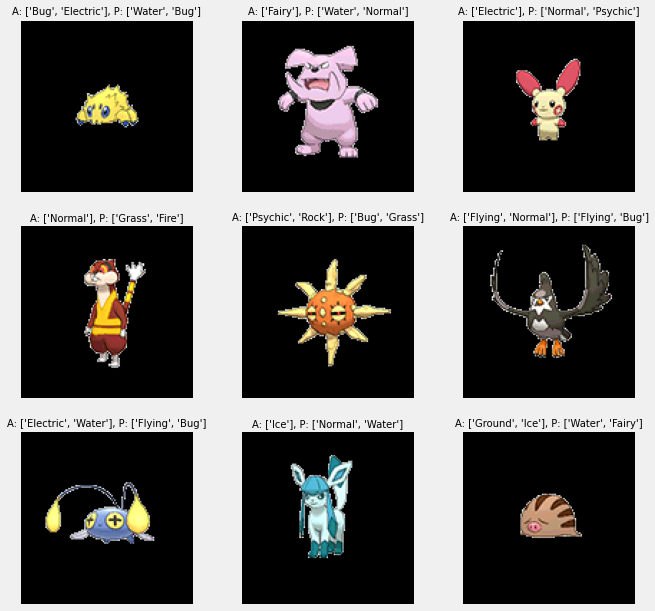

In [370]:
PRINT_TYPES = True

fig, axes = plt.subplots(3, 3, figsize=(10, 10))
axes.reshape(-1, 1)

for f, l in test_ds.take(1):
       
    
    # loop through one batch for N times 
    for i, ax in enumerate(axes.reshape(-1)):
        
        ax.imshow(f[i])
        ax.axis(False)
        
        # Make prediction on sample image from dataset 
        sample_img = np.expand_dims(f[i], axis=0)      
        pred_raw = model.predict(sample_img)
        pred_soft = tf.keras.layers.Softmax()(pred_raw)  
        pred_idx = pred_soft[0].numpy().argsort()[-2:][::-1]       
       
        # Get actual label 
        idx_labels = np.where(l[i].numpy() == 1)[0] 
        
        # Write actual and prediction 
        if PRINT_TYPES: 
            act_types_str = [] 
            pred_types_str = [] 
            
            for idx in idx_labels: 
                act_types_str.append(type_encoding[idx])
            
            for idx in pred_idx: 
                pred_types_str.append(type_encoding[idx])
            
            idx_labels = act_types_str
            pred_idx = pred_types_str
            
        
        ax.set_title("A: {}, P: {}".format(idx_labels, pred_idx), size=10)
        

```
TYPE ENCODING: 

0. Bug
1. Dark
2. Dragon
3. Electric
4. Fairy
5. Fighting
6. Fire
7. Flying
8. Ghost
9. Grass
10. Ground
11. Ice
12. Normal
13. Poison
14. Psychic
15. Rock
16. Steel
17. Water
```

## Save model 

In [382]:
import datetime
import os 

dirname = "saved_models/" + str(datetime.date.today()) + "-pokemodel"

os.mkdir('saved_models/')
os.mkdir(dirname)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'saved_models/'

In [384]:
model.save(dirname)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: saved_models/2020-05-19-pokemodel\assets


In [385]:
!ls $dirname

assets
saved_model.pb
variables


### load model and test 

In [386]:
new_model = tf.keras.models.load_model(dirname)

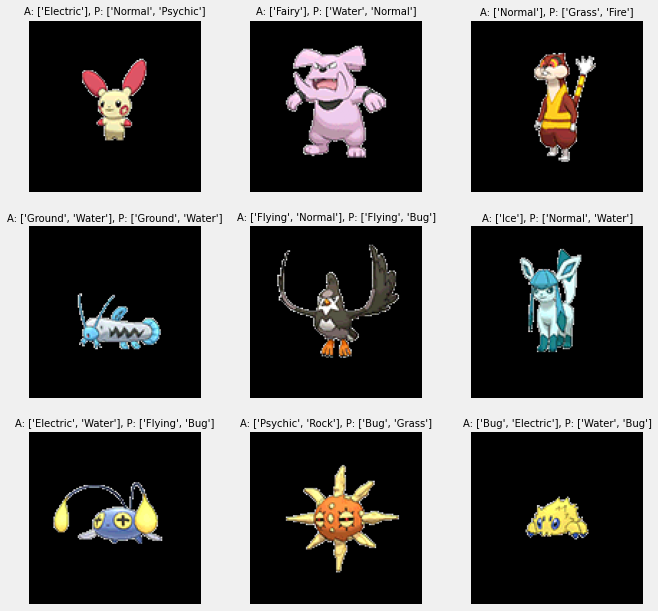

In [389]:
PRINT_TYPES = True

fig, axes = plt.subplots(3, 3, figsize=(10, 10))
axes.reshape(-1, 1)

for f, l in test_ds.take(1):
       
    
    # loop through one batch for N times 
    for i, ax in enumerate(axes.reshape(-1)):
        
        ax.imshow(f[i])
        ax.axis(False)
        
        # Make prediction on sample image from dataset 
        sample_img = np.expand_dims(f[i], axis=0)      
        pred_raw = new_model.predict(sample_img)
        pred_soft = tf.keras.layers.Softmax()(pred_raw)  
        pred_idx = pred_soft[0].numpy().argsort()[-2:][::-1]       
       
        # Get actual label 
        idx_labels = np.where(l[i].numpy() == 1)[0] 
        
        # Write actual and prediction 
        if PRINT_TYPES: 
            act_types_str = [] 
            pred_types_str = [] 
            
            for idx in idx_labels: 
                act_types_str.append(type_encoding[idx])
            
            for idx in pred_idx: 
                pred_types_str.append(type_encoding[idx])
            
            idx_labels = act_types_str
            pred_idx = pred_types_str
            
        
        ax.set_title("A: {}, P: {}".format(idx_labels, pred_idx), size=10)
        

In [391]:
def plot_prediction_grid(model, dataset, print_types=True):
    """ Plots a prediction grid given an model and dataset 
    
    model:   tf model 
    dataset:  tf.data.Dataset 
    print_types:  If True, will lookup string names for types 
    """

    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    axes.reshape(-1, 1)

    for f, l in dataset.take(1):


        # loop through one batch for N times 
        for i, ax in enumerate(axes.reshape(-1)):

            ax.imshow(f[i])
            ax.axis(False)

            # Make prediction on sample image from dataset 
            sample_img = np.expand_dims(f[i], axis=0)      
            pred_raw = model.predict(sample_img)
            pred_soft = tf.keras.layers.Softmax()(pred_raw)  
            pred_idx = pred_soft[0].numpy().argsort()[-2:][::-1]       

            # Get actual label 
            idx_labels = np.where(l[i].numpy() == 1)[0] 

            # Write actual and prediction 
            if print_types: 
                act_types_str = [] 
                pred_types_str = [] 

                for idx in idx_labels: 
                    act_types_str.append(type_encoding[idx])

                for idx in pred_idx: 
                    pred_types_str.append(type_encoding[idx])

                idx_labels = act_types_str
                pred_idx = pred_types_str


            ax.set_title("A: {}, P: {}".format(idx_labels, pred_idx), size=10)


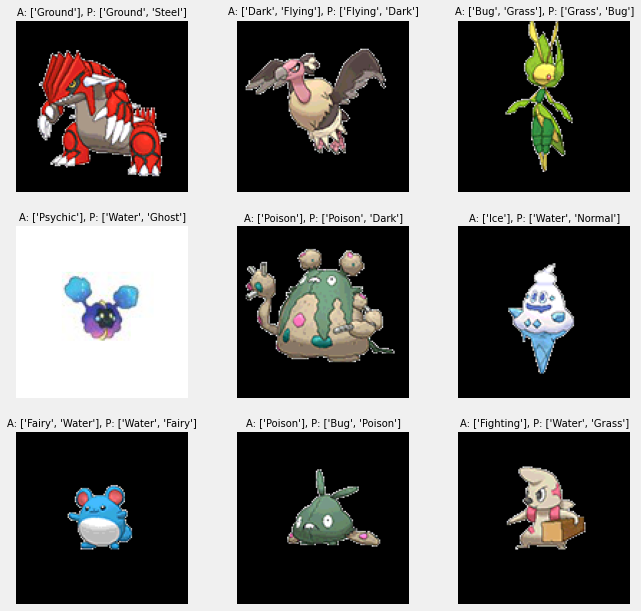

In [392]:
plot_prediction_grid(model, train_ds, True)